# EDA for Game Reviews data

In [1]:
import duckdb
import polars as pl
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
db_conn = duckdb.connect("../data/steam.duckdb", read_only=True)
games_df = db_conn.sql("""
                       WITH latest_game_entries AS (
                           SELECT game_id,
                                  game_review_day,
                                  game_scrape_date,
                                  game_weighted_score,
                                  game_num_reviews,
                                  game_num_positive_reviews,
                                  game_num_negative_reviews
                           FROM (SELECT game_id,
                                        game_review_day,
                                        game_scrape_date,
                                        game_weighted_score,
                                        game_num_reviews,
                                        game_num_positive_reviews,
                                        game_num_negative_reviews,
                                        ROW_NUMBER() OVER (
                PARTITION BY game_id
                ORDER BY game_review_day DESC, game_scrape_date DESC
            ) as rn
                                 FROM game_features)
                           WHERE rn = 1)
                       SELECT dg.*, lge.game_num_reviews, lge.game_weighted_score, lge.game_num_positive_reviews, lge.game_num_negative_reviews
                       FROM dim_games AS dg
                                JOIN
                            latest_game_entries AS lge
                            ON
                                dg.game_id = lge.game_id;
                       """).pl()
db_conn.close()

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

In [3]:
def show_distplot_sparse_cat(df: pl.DataFrame, col_name: str, quantiles: list | None = None, colors: list | None = None,
                             log_scale: bool = True):
    if quantiles is None:
        quantiles = [0.25, 0.5, 0.75]
    if colors is None:
        colors = ["blue", "green", "red"]
    exploded_df = df.explode(col_name).group_by(col_name).agg(
        pl.len().alias("count"),
        (pl.sum("game_num_positive_reviews").alias("positive_reviews") / pl.len().alias("count")).alias(
            "avg_pos_reviews"),
        pl.col("game_name")
    ).sort("avg_pos_reviews", descending=True)
    ax = sns.histplot(exploded_df["count"], bins=20, log_scale=log_scale, kde=True)
    for quant, color in zip(quantiles, colors):
        ax.axvline(exploded_df["count"].quantile(quant), color=color, linestyle="dashed",
                   label=f"{quant} quantile ({exploded_df['count'].quantile(quant)})")
    ax.legend(title="plot stats")
    return exploded_df

In [4]:
games_df.sort("game_num_reviews", descending=True)

game_index,game_id,game_name,game_is_free,game_developers,game_publishers,game_categories,game_genres,game_steam_release_date,game_release_date,game_prerelease_date,game_short_description,game_about,game_detailed_description,game_scrape_date,game_review_score,game_review_score_description,game_num_reviews,game_weighted_score,game_num_positive_reviews,game_num_negative_reviews
i64,i64,str,bool,list[str],list[str],list[str],list[str],datetime[μs],"datetime[μs, America/Lima]","datetime[μs, America/Lima]",str,str,str,date,i64,str,i64,f64,"decimal[38,0]","decimal[38,0]"
11545,578080,"""PUBG: BATTLEGROUNDS""",true,"[""PUBG Corporation""]","[""KRAFTON, Inc.""]","[""Multi-player"", ""PvP"", … ""Remote Play on Tablet""]","[""Action"", ""Adventure"", … ""Free To Play""]",2017-12-21 00:00:00,2017-12-21 00:00:00 -05,2017-03-23 10:25:15 -05,"""PUBG: BATTLEGROUNDS, the high-…","""LAND Drop into an ever-growing…","""LAND Drop into an ever-growing…",2025-08-12,5,"""Mixed""",1746069,0.55522,970793,775276
950,105600,"""Terraria""",false,"[""Re-Logic""]","[""Re-Logic""]","[""Single-player"", ""Multi-player"", … ""Family Sharing""]","[""Action"", ""Adventure"", … ""RPG""]",2011-05-16 00:00:00,2011-05-16 00:00:00 -05,2011-05-16 00:00:00 -05,"""Dig, fight, explore, build! No…","""Dig, Fight, Explore, Build: Th…","""Dig, Fight, Explore, Build: Th…",2025-08-12,9,"""Overwhelmingly Positive""",1141224,0.978078,1114096,27128
1959,252490,"""Rust""",false,"[""Facepunch Studios""]","[""Facepunch Studios""]","[""Multi-player"", ""MMO"", … ""Remote Play on Tablet""]","[""Action"", ""Adventure"", … ""RPG""]",2018-02-08 00:00:00,2018-02-08 00:00:00 -05,2013-12-11 13:42:09 -05,"""The only aim in Rust is to sur…","""The only aim in Rust is to sur…","""The only aim in Rust is to sur…",2025-08-12,8,"""Very Positive""",1040475,0.876089,910907,129568
84613,2358720,"""Black Myth: Wukong""",false,"[""Game Science""]","[""Game Science""]","[""Single-player"", ""Steam Achievements"", … ""Family Sharing""]","[""Action"", ""Adventure"", ""RPG""]",2024-08-19 00:00:00,2024-08-19 00:00:00 -05,2024-08-19 00:00:00 -05,"""Black Myth: Wukong is an actio…","""Black Myth: Wukong is an actio…","""Digital Deluxe Edition The Bla…",2025-08-12,8,"""Very Positive""",852419,0.96651,822781,29638
9202,431960,"""Wallpaper Engine""",false,"[""Wallpaper Engine Team""]","[""Wallpaper Engine Team""]","[""Steam Achievements"", ""Steam Trading Cards"", … ""Includes level editor""]","[""Casual"", ""Indie"", … ""Utilities""]",2018-11-16 00:00:00,2018-11-16 00:00:00 -05,2016-10-10 14:39:08 -05,"""Use stunning live wallpapers o…","""Wallpaper Engine enables you t…","""Wallpaper Engine enables you t…",2025-08-12,9,"""Overwhelmingly Positive""",849357,0.980876,832798,16559
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
100346,3672420,"""OneOne""",false,"[""Abyss Tech""]","[""Abyss Tech""]","[""Single-player"", ""Steam Achievements"", … ""Family Sharing""]","[""Adventure"", ""Casual"", ""Indie""]",2025-06-17 00:00:00,2025-06-17 00:00:00 -05,2025-06-17 00:00:00 -05,"""一段探寻人类智能本质的逃亡之旅，基于现实世界观下的非幻想题材…","""这是一本以 动态像素绘本 的形式呈现给大家的 【智能科幻寓言…","""这是一本以 动态像素绘本 的形式呈现给大家的 【智能科幻寓言…",2025-08-12,0,"""No user reviews""",1,1.0,1,0
101132,3768660,"""About a Boy""",false,"[""Return 0 Game Studio""]","[""P.R.A.R""]","[""Single-player"", ""Family Sharing""]","[""Adventure"", ""Casual"", ""Indie""]",2025-06-29 00:00:00,2025-06-29 00:00:00 -05,2025-06-29 00:00:00 -05,"""“About a Boy” immerses players…","""About a Boy tells the story of…","""About a Boy tells the story of…",2025-08-12,0,"""1 user reviews""",1,0.0,0,1
102531,3853710,"""Panin""",false,"[""TCL""]","[""TCLEZ""]","[""Single-player"", ""Color Alternatives"", … ""Family Sharing""]","[""Adventure"", ""Casual"", … ""Strategy""]",2025-07-24 00:00:00,2025-07-24 00:00:00 -05,2025-07-24 00:00:00 -05,"""&quot;Panin&quot; is a single-…","""Panin A single-player puzzle g…","""Panin A single-player puzzle g…",2025-08-12,0,"""No user reviews""",1,1.0,1,0


In [5]:
games_df["game_num_reviews"].describe()

statistic,value
str,f64
"""count""",83194.0
"""null_count""",0.0
"""mean""",1092.79204
"""std""",15383.261347
"""min""",1.0
"""25%""",4.0
"""50%""",16.0
"""75%""",86.0
"""max""",1.746069e6


### EDA
* QUESTION: ARE THERE LARGE ENOUGH CLUSTERS (BY game_developer, game_publisher, genre, categories) TO FIND SIMILAR GAMES?
* Num reviews is biased by price, pc specs, single-player / multiplayer

    (Find similar games and try establishing bias between single-player / multiplayer and number of reviews)
* Correlation between months since release and number of reviews (positive / negative)
* Correlation between months since release and game review score
* Correlation between is_free and number of reviews (see Welch t-test, Mann-Whitney U, permutation test)
* Game developers and publishers for similar games
* Way to find similarity between games
* Analysis of game description

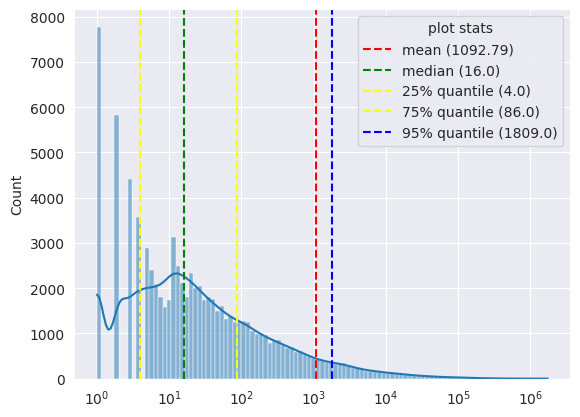

In [7]:
ax = sns.histplot(games_df["game_num_reviews"], log_scale=True, kde=True)
ax.axvline(games_df["game_num_reviews"].mean(), color="red", linestyle="dashed",
           label=f"mean ({games_df['game_num_reviews'].mean():.2f})")
ax.axvline(games_df["game_num_reviews"].median(), color="green", linestyle="dashed",
           label=f"median ({games_df['game_num_reviews'].median()})")
ax.axvline(games_df["game_num_reviews"].quantile(0.25), color="yellow", linestyle="dashed",
           label=f"25% quantile ({games_df['game_num_reviews'].quantile(0.25)})")
ax.axvline(games_df["game_num_reviews"].quantile(0.75), color="yellow", linestyle="dashed",
           label=f"75% quantile ({games_df['game_num_reviews'].quantile(0.75)})")
ax.axvline(games_df["game_num_reviews"].quantile(0.95), color="blue", linestyle="dashed",
           label=f"95% quantile ({games_df['game_num_reviews'].quantile(0.95)})")
ax.legend(title="plot stats")

<Axes: ylabel='Count'>

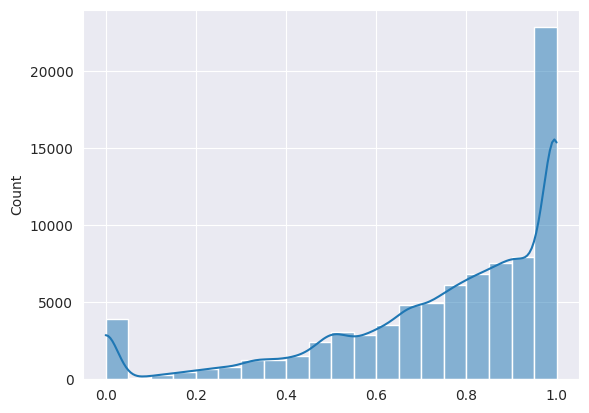

In [8]:
sns.histplot(games_df["game_weighted_score"], bins=20, kde=True)  # Too much games with score 1 ?

<Axes: ylabel='Count'>

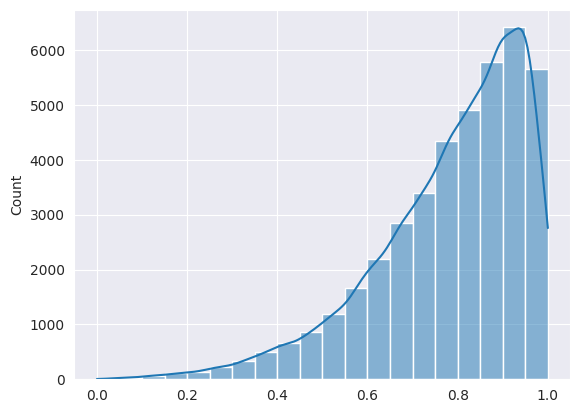

In [9]:
sns.histplot(
    games_df.filter(pl.col("game_num_reviews") > pl.col("game_num_reviews").quantile(0.5))["game_weighted_score"],
    bins=20, kde=True)  # less reviews are biased towards having score 1
# IDEA: feature: num_reviews_[cat] * game_score (crossed feature)

In [10]:
bottom_95_games = games_df.filter(pl.col("game_num_reviews") <= games_df["game_num_reviews"].quantile(0.95))
top_95_games = games_df.filter(pl.col("game_num_reviews") > games_df["game_num_reviews"].quantile(0.95))

<Axes: xlabel='game_num_reviews', ylabel='game_weighted_score'>

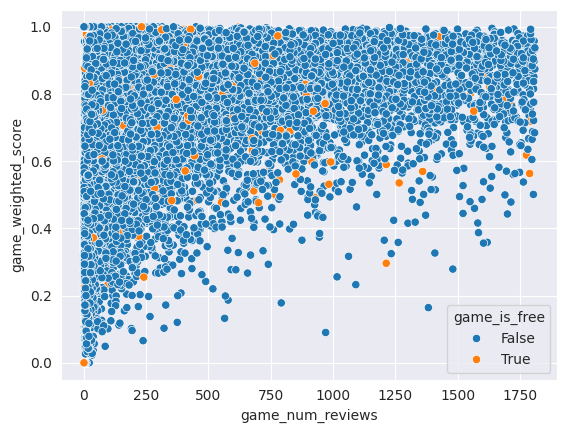

In [11]:
sns.scatterplot(x=bottom_95_games["game_num_reviews"], y=bottom_95_games["game_weighted_score"],
                hue=bottom_95_games["game_is_free"])

<Axes: xlabel='game_num_reviews', ylabel='game_weighted_score'>

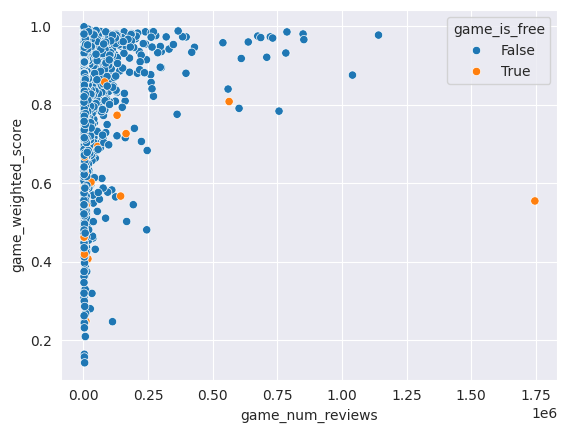

In [12]:
sns.scatterplot(x=top_95_games["game_num_reviews"], y=top_95_games["game_weighted_score"],
                hue=top_95_games["game_is_free"])

**NOTE**: Games score tends to increase with the number of reviews, no perceivable difference between free / non-free games

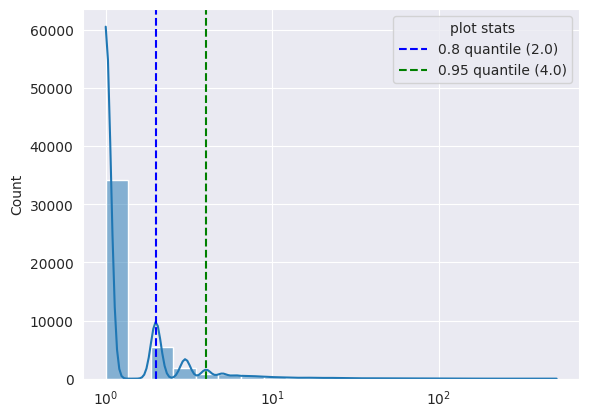

In [13]:
publishers = show_distplot_sparse_cat(games_df, "game_publishers", [0.8, 0.95])

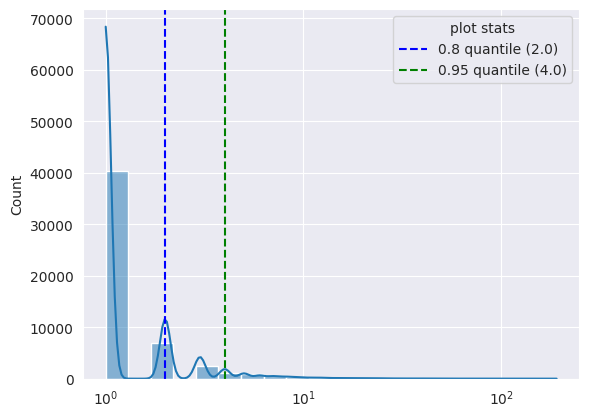

In [14]:
developers = show_distplot_sparse_cat(games_df, "game_developers", [0.8, 0.95])

**NOTE** : there are some games with empty publishers and developers

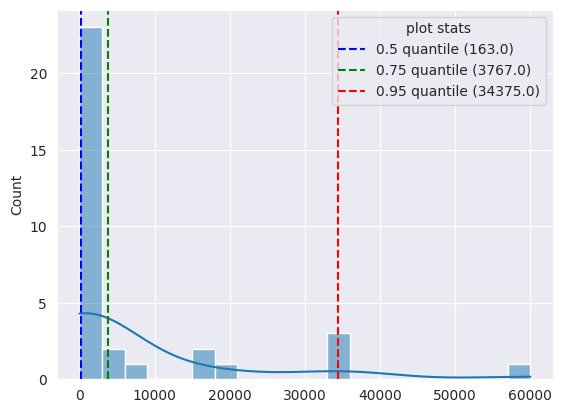

In [15]:
genres = show_distplot_sparse_cat(games_df, "game_genres", quantiles=[0.5, 0.75, 0.95], log_scale=False)

<Axes: xlabel='game_genres', ylabel='count'>

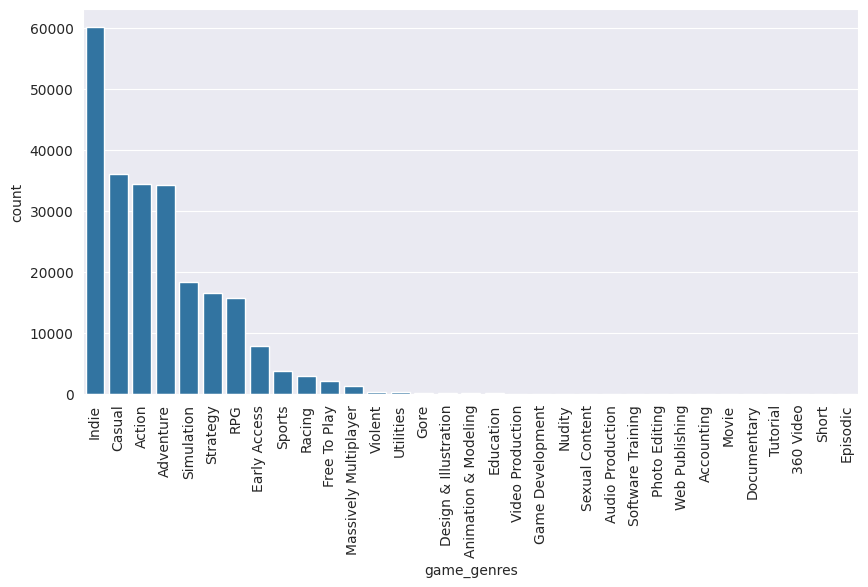

In [16]:
ax = plt.figure(figsize=(10, 5))
plt.xticks(rotation=90)
order = genres.sort("count", descending=True)["game_genres"]
sns.barplot(x=genres["game_genres"], y=genres["count"], order=order)

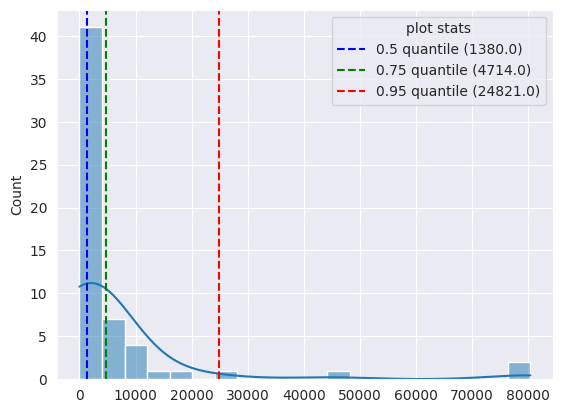

In [17]:
categories = show_distplot_sparse_cat(games_df, "game_categories", quantiles=[0.5, 0.75, 0.95], log_scale=False)

<Axes: xlabel='game_categories', ylabel='count'>

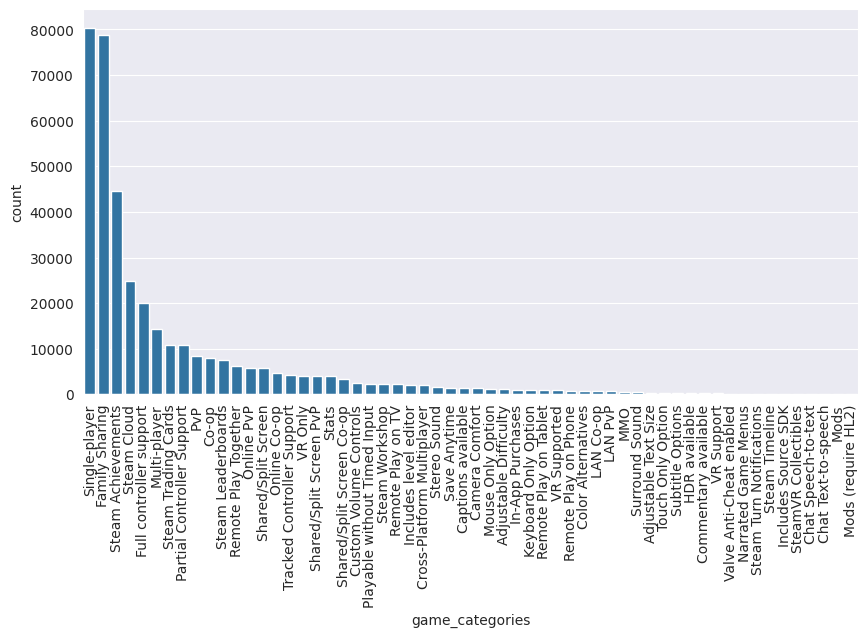

In [18]:
ax = plt.figure(figsize=(10, 5))
plt.xticks(rotation=90)
order = categories.sort("count", descending=True)["game_categories"]
sns.barplot(x=categories["game_categories"], y=categories["count"], order=order)

### Possible features
- description embedding
- game num reviews (50 - 75 - 95 percentiles)
- game score  (crossed with num reviews)
- is free
- publishers embedding
- developers embedding
- genre embedding
- category embedding
- months since release

Let's start with all non-text features: game_num_reviews , game_weighted_score, is_free, months_since_release

In [19]:
non_text_feats = games_df.select(
    "game_name",
    "game_weighted_score",
    "game_is_free",
    "game_num_reviews",
    pl.when(pl.col("game_num_reviews") <= 0).then(pl.lit("no_reviews"))
    .when(pl.col("game_num_reviews") <= pl.col("game_num_reviews").quantile(0.5)).then(pl.lit("low_reviews"))
    .when(pl.col("game_num_reviews") <= pl.col("game_num_reviews").quantile(0.75)).then(pl.lit("moderate_reviews"))
    .when(pl.col("game_num_reviews") <= pl.col("game_num_reviews").quantile(0.95)).then(pl.lit("high_reviews"))
    .otherwise(pl.lit("very_high_reviews")).alias("game_num_reviews_cat"),
    (pl.col("game_review_day").sub(pl.col("game_prerelease_date")).dt.total_days() / 365.25).alias(
        "years_since_release")
)
non_text_feats

game_name,game_weighted_score,game_is_free,game_num_reviews,game_num_reviews_cat,years_since_release
str,f64,bool,i64,str,f64
"""Heileen 2: The Hands Of Fate""",0.588794,false,19,"""moderate_reviews""",6.507871
"""Survival Games""",0.470228,false,38,"""moderate_reviews""",5.97399
"""Gold Rush! Classic""",0.891309,false,73,"""moderate_reviews""",10.819986
"""Pacific Liberation Force""",0.272575,false,17,"""moderate_reviews""",10.584531
"""Thieves' Gambit: The Curse of …",0.823949,false,28,"""moderate_reviews""",6.313484
…,…,…,…,…,…
"""Thirst VR""",0.759715,false,108,"""high_reviews""",8.465435
"""Stay! Stay! Democratic People'…",0.95234,false,502,"""high_reviews""",8.134155
"""69 Ways to Kill a Zombie""",0.646565,false,62,"""moderate_reviews""",8.930869


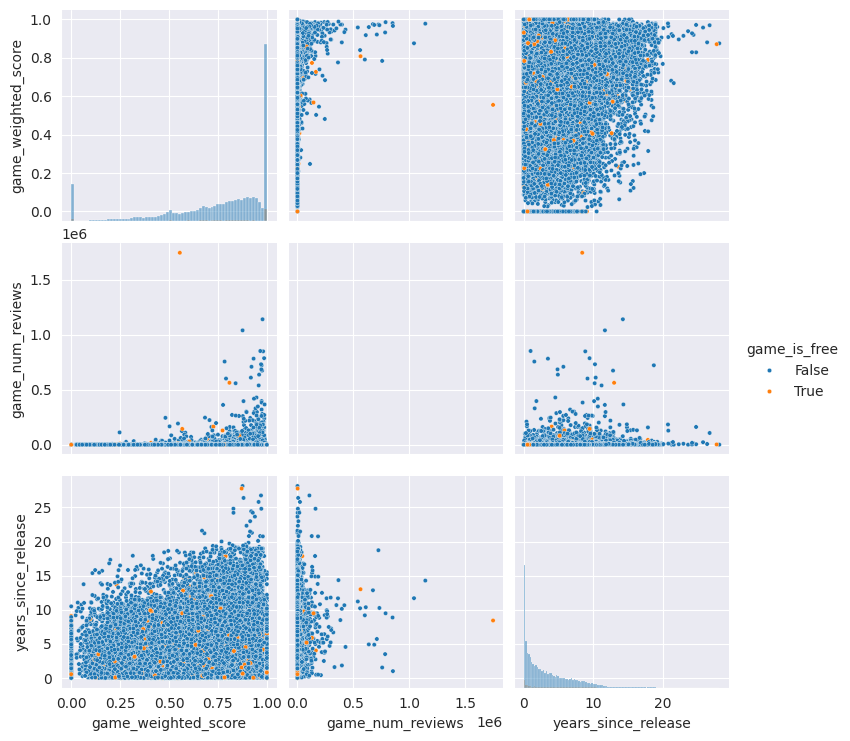

In [31]:
plt.close()
sns.pairplot(non_text_feats.to_pandas(), hue="game_is_free", kind="scatter", diag_kind="hist", plot_kws=dict(s=10))

<Axes: xlabel='game_num_reviews_cat', ylabel='game_weighted_score'>

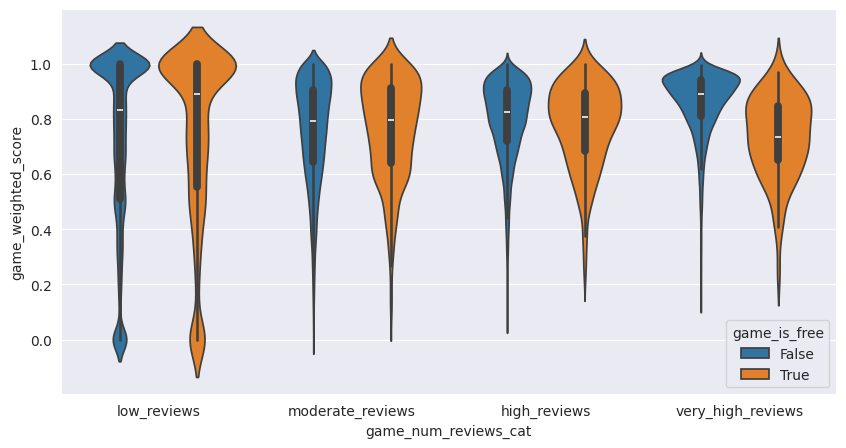

In [21]:
ax = plt.figure(figsize=(10, 5))
sns.violinplot(x=non_text_feats["game_num_reviews_cat"], y=non_text_feats["game_weighted_score"],
               hue=non_text_feats["game_is_free"],
               order=["low_reviews", "moderate_reviews", "high_reviews", "very_high_reviews"])

<Axes: xlabel='game_num_reviews_cat', ylabel='years_since_release'>

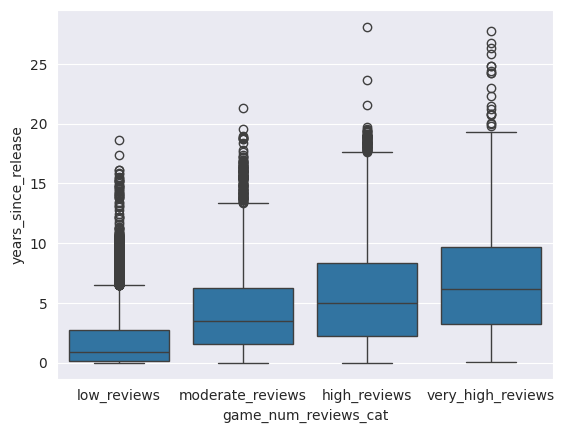

In [22]:
sns.boxplot(x="game_num_reviews_cat", y="years_since_release", data=non_text_feats,
            order=["low_reviews", "moderate_reviews", "high_reviews", "very_high_reviews"])

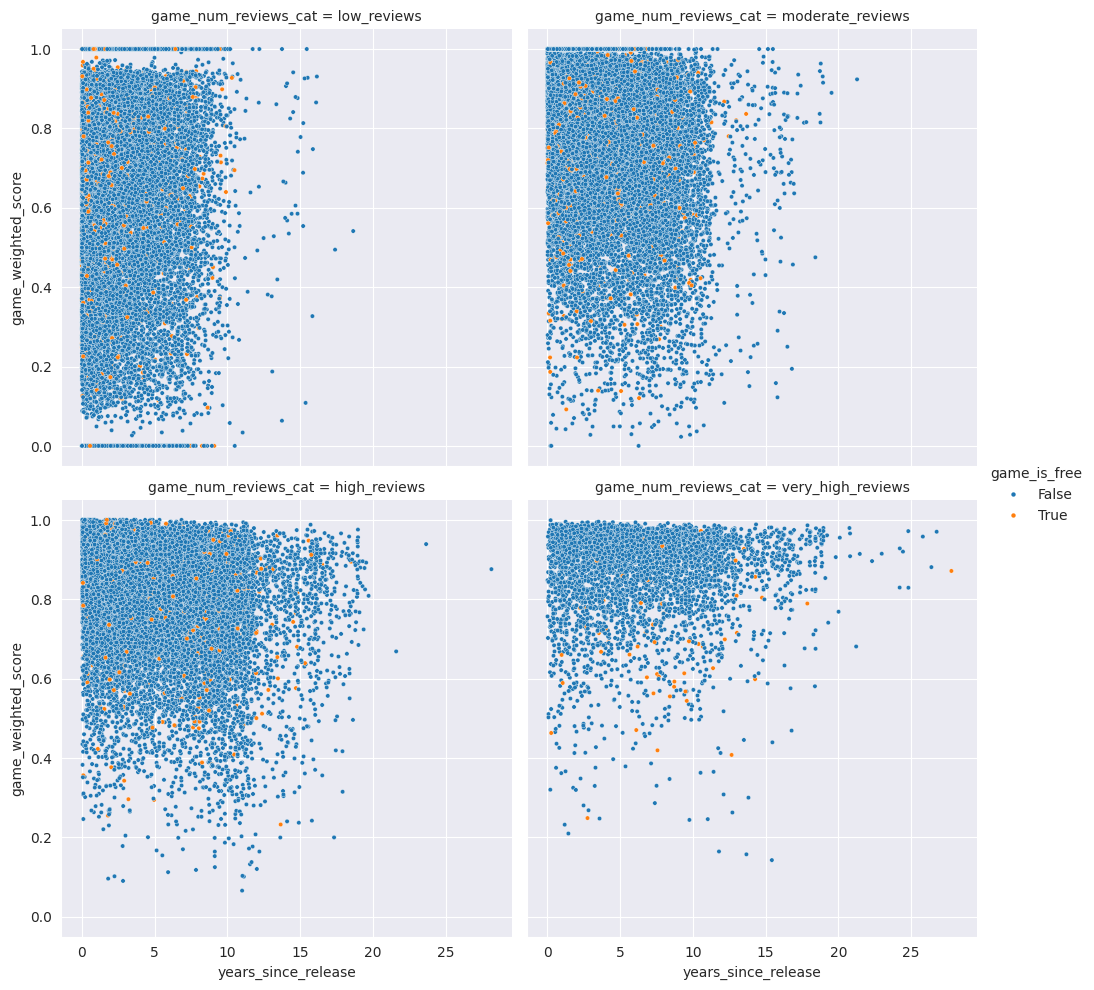

In [30]:
sns.relplot(
    data=non_text_feats,
    x="years_since_release",
    y="game_weighted_score",
    col="game_num_reviews_cat",
    hue="game_is_free",
    col_wrap=2,
    col_order=["low_reviews", "moderate_reviews", "high_reviews", "very_high_reviews"],
    s=10
)

**NOTE**:
- There are not much old games with low / moderate reviews, most old games have high scores since lower score ones are probably forgotten
- With very low reviews they are usually at the limits (0 positive, 0 negative)

### Small test with Game Encodings

In [6]:
from sentence_transformers import SentenceTransformer

In [7]:
model = SentenceTransformer("all-MiniLM-L6-v2")

In [25]:
model.max_seq_length

256

In [15]:
games_len = games_df.with_columns(
    pl.col("game_detailed_description").str.len_chars().alias("game_detailed_description_len"),
    pl.col("game_short_description").str.len_chars().alias("game_short_description_len")
)

In [16]:
games_len

game_index,game_id,game_name,game_is_free,game_developers,game_publishers,game_categories,game_genres,game_steam_release_date,game_release_date,game_prerelease_date,game_short_description,game_about,game_detailed_description,game_scrape_date,game_review_score,game_review_score_description,game_num_reviews,game_weighted_score,game_num_positive_reviews,game_num_negative_reviews,game_detailed_description_len,game_short_description_len
i64,i64,str,bool,list[str],list[str],list[str],list[str],datetime[μs],"datetime[μs, America/Lima]","datetime[μs, America/Lima]",str,str,str,date,i64,str,i64,f64,"decimal[38,0]","decimal[38,0]",u32,u32
75244,2775310,"""Disappearance - Takeshi. You w…",false,"[""HAZECODE""]","[""HAZECODE""]","[""Single-player"", ""Partial Controller Support"", ""Family Sharing""]","[""Action"", ""Adventure"", ""Indie""]",2024-01-28 00:00:00,2024-01-28 00:00:00 -05,2024-01-28 00:00:00 -05,"""&quot;Disappearance - Takeshi.…","""""Disappearance - Takeshi. You …","""""Disappearance - Takeshi. You …",2025-08-12,0,"""No user reviews""",65,0.895193,58,7,1281,203
76030,2783990,"""The Dark Story""",false,"[""MY DREAM GAME STUDIO""]","[""MY DREAM GAME STUDIO""]","[""Single-player"", ""Family Sharing""]","[""Action"", ""Adventure"", ""Indie""]",2024-02-15 00:00:00,2024-02-15 00:00:00 -05,2024-02-15 00:00:00 -05,"""Welcome to THE DARK STORY get …","""WELCOME TO THE DARK STORY Get …","""WELCOME TO THE DARK STORY Get …",2025-08-12,0,"""No user reviews""",1,1.0,1,0,1629,260
80895,2805060,"""Diabotical Rogue""",false,"[""GD Studio Inc""]","[""GD Studio Inc""]","[""Multi-player"", ""PvP"", … ""Family Sharing""]","[""Action"", ""Early Access""]",2024-06-04 00:00:00,2024-06-04 00:00:00 -05,2024-06-04 00:00:00 -05,"""Welcome to our online first-pe…","""An online, PvP, first-person s…","""An online, PvP, first-person s…",2025-08-12,6,"""Mostly Positive""",444,0.71482,318,126,1598,216
97413,2805770,"""Elements Divided""",false,"[""Loco Motion Devs""]","[""Fast Travel Games""]","[""Single-player"", ""Multi-player"", … ""Family Sharing""]","[""Action""]",2025-04-23 00:00:00,2025-04-23 00:00:00 -05,2025-04-23 00:00:00 -05,"""Bend fire, water, earth and ai…","""Bend fire, water, earth and ai…","""Bend fire, water, earth and ai…",2025-08-12,7,"""Positive""",64,0.950928,61,3,760,258
77469,2807110,"""Clocked""",false,"[""Cykodd Production""]","[""Cykodd Production""]","[""Single-player"", ""Steam Achievements"", … ""Family Sharing""]","[""Adventure"", ""Casual"", ""Indie""]",2024-03-20 00:00:00,2024-03-20 00:00:00 -05,2024-03-20 00:00:00 -05,"""Two worlds coexist, but one of…","""The adventure takes place in a…","""The adventure takes place in a…",2025-08-12,0,"""No user reviews""",2,1.0,2,0,1554,257
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
34110,431940,"""Wildfire""",false,"[""Sneaky Bastards""]","[""Humble Games""]","[""Single-player"", ""Multi-player"", … ""Family Sharing""]","[""Indie""]",2020-05-25 00:00:00,2020-05-25 00:00:00 -05,2020-05-25 00:00:00 -05,"""Master the elements in this st…","""Master the elements in this st…","""Master the elements in this st…",2025-08-12,8,"""Very Positive""",413,0.855006,351,62,1491,210
8329,436060,"""Lolly Joe""",false,"[""Peter Valencia""]","[""Peter Valencia""]","[""Single-player"", ""Steam Achievements"", … ""Family Sharing""]","[""Action"", ""Adventure"", ""Indie""]",2016-08-05 00:00:00,2016-08-05 00:00:00 -05,2016-08-05 00:00:00 -05,"""A dog's journey to reunite wit…","""A dog's journey to reunite wit…","""A dog's journey to reunite wit…",2025-08-12,0,"""5 user reviews""",10,0.574272,6,4,697,278
7682,443250,"""Legacy of the Elder Star""",true,"[""Kickbomb Entertainment LLC""]","[""Kickbomb Entertainment LLC""]","[""Single-player"", ""Steam Achievements"", … ""Steam Leaderboards""]","[""Action"", ""Indie""]",2016-06-07 00:00:00,2016-06-07 00:00:00 -05,2016-06-07 00:00:00 -05,"""Legacy of the Elder Star is a …","""Legacy of the Elder Star is a …","""Legacy of the Elder Star is a …",2025-08-12,5,"""

<Axes: ylabel='Count'>

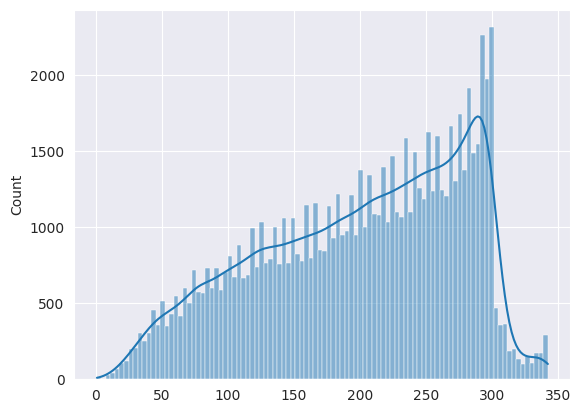

In [19]:
sns.histplot(games_len["game_short_description_len"], bins=100, kde=True)

<Axes: ylabel='Count'>

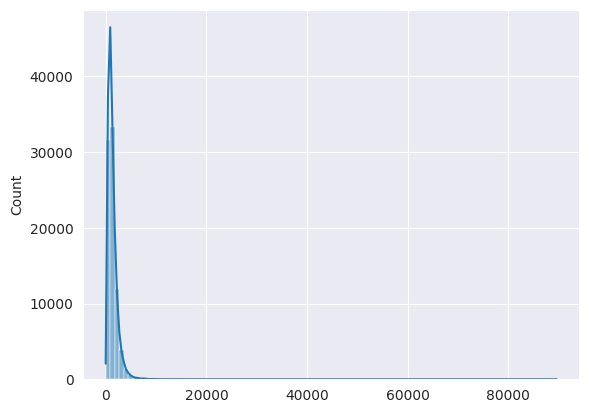

In [20]:
sns.histplot(games_len["game_detailed_description_len"], bins=100, kde=True)

<Axes: xlabel='game_detailed_description_len', ylabel='game_num_reviews'>

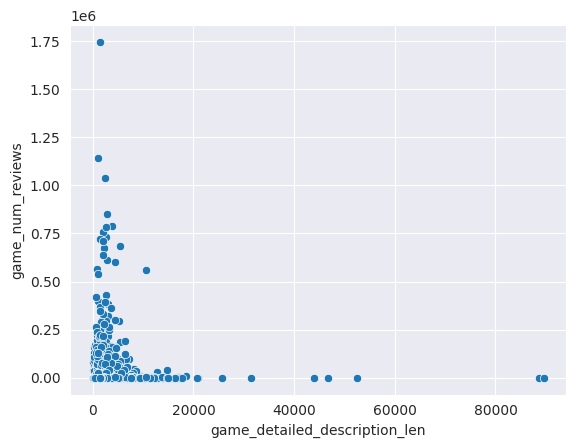

In [30]:
sns.scatterplot(x=games_len["game_detailed_description_len"], y=games_len["game_num_reviews"])

In [26]:
games_len.filter(pl.col("game_detailed_description_len") > 10000).sort("game_detailed_description_len")

game_index,game_id,game_name,game_is_free,game_developers,game_publishers,game_categories,game_genres,game_steam_release_date,game_release_date,game_prerelease_date,game_short_description,game_about,game_detailed_description,game_scrape_date,game_review_score,game_review_score_description,game_num_reviews,game_weighted_score,game_num_positive_reviews,game_num_negative_reviews,game_detailed_description_len,game_short_description_len
i64,i64,str,bool,list[str],list[str],list[str],list[str],datetime[μs],"datetime[μs, America/Lima]","datetime[μs, America/Lima]",str,str,str,date,i64,str,i64,f64,"decimal[38,0]","decimal[38,0]",u32,u32
41331,1544250,"""Trickery&Strategy""",false,"[""Ian Young""]","[""Ian Young""]","[""Single-player"", ""Multi-player"", … ""Family Sharing""]","[""Indie"", ""Simulation"", ""Strategy""]",2021-03-02 00:00:00,2021-03-02 00:00:00 -05,2021-03-02 00:00:00 -05,"""This is a war chess strategy g…","""In the game, the player plays …","""Special notice English text tr…",2025-08-12,0,"""No user reviews""",11,0.832382,9,2,10081,277
25346,941300,"""TouHou Nil Soul""",false,"[""Re零同人社"", ""二色幽紫蝶""]","[""二色幽紫蝶""]","[""Single-player"", ""Steam Achievements"", ""Family Sharing""]","[""Indie"", ""RPG"", ""Strategy""]",2020-02-28 00:00:00,2020-02-28 00:00:00 -05,2019-03-21 23:58:01 -05,"""Scarlet Devil Mansion is askin…","""Story Scarlet Devil Mansion is…","""SoundTrak About the Game Story…",2025-08-12,0,"""8 user reviews""",134,0.841392,113,21,10240,272
14799,688930,"""City of Ages: Picture Supporti…",true,"[""Darren N Lory""]","[""Formsmatter""]","[""Single-player"", ""Multi-player"", … ""Remote Play Together""]","[""Adventure"", ""Indie"", … ""Strategy""]",2017-10-13 00:00:00,2017-10-13 00:00:00 -05,2017-10-13 00:00:00 -05,"""Two windows applications insta…","""City of Ages Code: Safari [530…","""City of Ages Code: Safari [530…",2025-08-12,0,"""7 user reviews""",11,0.735445,8,3,10353,250
87526,3107770,"""Geo-Political Simulator 5""",false,"[""Eversim""]","[""Eversim""]","[""Single-player"", ""Family Sharing""]","[""Simulation"", ""Strategy""]",2024-10-22 00:00:00,2024-10-22 00:00:00 -05,2024-10-22 00:00:00 -05,"""The new 5th edition of the hyp…","""GPS5: THE ULTIMATE SIMULATION …","""GPS5: THE ULTIMATE SIMULATION …",2025-08-12,5,"""Mixed""",327,0.348365,120,207,10382,295
5710,369990,"""Gremlins, Inc.""",false,"[""Charlie Oscar Lima Tango Interactive Entertainment""]","[""The Merchant Guild of Rund (Limited)""]","[""Single-player"", ""Multi-player"", … ""Family Sharing""]","[""Indie"", ""Strategy""]",2016-03-10 00:00:00,2016-03-10 00:00:00 -05,2015-10-22 04:46:32 -05,"""This is an intense strategy bo…","""This is an intense strategy bo…","""This is an intense strategy bo…",2025-08-12,8,"""Very Positive""",6323,0.860955,5391,932,10495,292
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
2764,237310,"""Elsword""",true,"[""KOG""]","[""KOG Games""]","[""Single-player"", ""Multi-player"", … ""Partial Controller Support""]","[""Action"", ""Adventure"", … ""Free To Play""]",2014-07-02 00:00:00,2014-07-02 00:00:00 -05,2014-07-02 00:00:00 -05,"""Elsword is a free-to-play, onl…","""Elsword is a free-to-play, onl…","""Elsword’s Hyper Punch Master a…",2025-08-12,6,"""Mostly Positive""",54,0.743912,40,14,43973,130
86204,2329760,"""Vampire Memories - 吸血鬼的回忆""",false,"[""Queen Vampire""]","[""Queen Vampire""]","[""Single-player"", ""Steam Achievements"", … ""Family Sharing""]","[""Action"", ""Casual"", ""Indie""]",2024-09-24 00:00:00,2024-09-24 00:00:00 -05,2024-09-24 00:00:00 -05,"""This is a SHMUP/STG game that …","""------------------------------…","""------------------------------…",2025-08-12,0,"""No user reviews""",1,0.0,0,1,46716,280
16910,708820,"""Baby Hands""",false,"[""Chicken Waffle""]","[""Chicken Waffle""]","[""Single-player"", ""Steam Achievements"", … ""Family Sharing""]","[""Action"", ""Adventure"", … ""Simulation""]",2018-07-26 00:00:00,2018-07-26 00:00:00 -05,2018-01-30 14:41:13 -05,"""Hilarious retro parodies! Expe…",

In [8]:
game_indices = [
    11545,  # PUBG
    1959,  # Rust
    72417,  # COD MW3
    34525,  # Battlefield V
    85364,  # NBA 2K25
    39231,  # CyberPunk 2077
    4470,  # The Witcher 3
]

In [31]:
sample_games = games_len.filter(pl.col("game_index").is_in(game_indices))

In [32]:
sample_games

game_index,game_id,game_name,game_is_free,game_developers,game_publishers,game_categories,game_genres,game_steam_release_date,game_release_date,game_prerelease_date,game_short_description,game_about,game_detailed_description,game_scrape_date,game_review_score,game_review_score_description,game_num_reviews,game_weighted_score,game_num_positive_reviews,game_num_negative_reviews,game_detailed_description_len,game_short_description_len
i64,i64,str,bool,list[str],list[str],list[str],list[str],datetime[μs],"datetime[μs, America/Lima]","datetime[μs, America/Lima]",str,str,str,date,i64,str,i64,f64,"decimal[38,0]","decimal[38,0]",u32,u32
72417,3595270,"""Call of Duty®: Modern Warfare®…",false,"[""Sledgehammer Games"", ""Treyarch"", … ""Demonware""]","[""Activision""]","[""Single-player"", ""Multi-player"", … ""In-App Purchases""]","[""Action""]",2023-11-10 00:00:00,2023-11-10 00:00:00 -05,2023-11-10 00:00:00 -05,"""In the direct sequel to the re…","""ADAPT OR DIE IN A FIGHT AGAINS…","""ADAPT OR DIE IN A FIGHT AGAINS…",2025-08-12,4,"""Mostly Negative""",12971,0.324946,4541,8430,990,149
4470,292030,"""The Witcher 3: Wild Hunt""",false,"[""CD PROJEKT RED""]","[""CD PROJEKT RED""]","[""Single-player"", ""Steam Achievements"", … ""Family Sharing""]","[""RPG""]",2015-05-18 00:00:00,2015-05-18 00:00:00 -05,2015-05-18 00:00:00 -05,"""You are Geralt of Rivia, merce…","""One of the most acclaimed RPGs…","""DISCOVER THE STORY BEFORE THE …",2025-08-12,9,"""Overwhelmingly Positive""",731786,0.970493,708446,23340,2580,254
11545,578080,"""PUBG: BATTLEGROUNDS""",true,"[""PUBG Corporation""]","[""KRAFTON, Inc.""]","[""Multi-player"", ""PvP"", … ""Remote Play on Tablet""]","[""Action"", ""Adventure"", … ""Free To Play""]",2017-12-21 00:00:00,2017-12-21 00:00:00 -05,2017-03-23 10:25:15 -05,"""PUBG: BATTLEGROUNDS, the high-…","""LAND Drop into an ever-growing…","""LAND Drop into an ever-growing…",2025-08-12,5,"""Mixed""",1746069,0.55522,970793,775276,1412,248
85364,2878980,"""NBA 2K25""",false,"[""Visual Concepts""]","[""2K""]","[""Single-player"", ""Multi-player"", … ""Family Sharing""]","[""Simulation"", ""Sports""]",2024-10-28 00:00:00,2024-10-28 00:00:00 -05,2024-09-04 00:01:26 -05,"""Command every court with authe…","""Command every court with authe…","""NBA 2K25 All-Star Edition The …",2025-08-12,5,"""Mixed""",28040,0.595848,16787,11253,3300,187
39231,1091500,"""Cyberpunk 2077""",false,"[""CD PROJEKT RED""]","[""CD PROJEKT RED""]","[""Single-player"", ""Steam Achievements"", … ""Family Sharing""]","[""RPG""]",2020-12-09 00:00:00,2020-12-09 00:00:00 -05,2020-12-09 00:00:00 -05,"""Cyberpunk 2077 is an open-worl…","""Cyberpunk 2077 is an open-worl…","""Cyberpunk 2077: Ultimate Editi…",2025-08-12,8,"""Very Positive""",287291,0.933129,267289,20002,1617,178
34525,1238810,"""Battlefield™ V""",false,"[""DICE""]","[""Electronic Arts""]","[""Single-player"", ""Multi-player"", … ""HDR available""]","[""Action""]",2020-10-22 00:00:00,2020-10-22 00:00:00 -05,2020-06-11 12:43:37 -05,"""This is the ultimate Battlefie…","""This is the ultimate Battlefie…","""This is the ultimate Battlefie…",2025-08-12,6,"""Mostly Positive""",223969,0.70693,158563,65406,872,193
1959,252490,"""Rust""",false,"[""Facepunch Studios""]","[""Facepunch Studios""]","[""Multi-player"", ""MMO"", … ""Remote Play on Tablet""]","[""Action"", ""Adventure"", … ""RPG""]",2018-02-08 00:00:00,2018-02-08 00:00:00 -05,2013-12-11 13:42:09 -05,"""The only aim in Rust is to sur…","""The only aim in Rust is to sur…","""The only aim in Rust is to sur…",2025-08-12,8,"""Very Positive""",1040475,0.876089,910907,129568,2426,189


In [11]:
embeddings = model.encode(sample_games["game_detailed_description"])

In [12]:
embeddings.shape

(7, 384)

In [13]:
sim_matrix = model.similarity(embeddings, embeddings)
sim_matrix

tensor([[1.0000, 0.3422, 0.4481, 0.0467, 0.3556, 0.4675, 0.3093],
        [0.3422, 1.0000, 0.3128, 0.0967, 0.3385, 0.3022, 0.3415],
        [0.4481, 0.3128, 1.0000, 0.1586, 0.4427, 0.3183, 0.3311],
        [0.0467, 0.0967, 0.1586, 1.0000, 0.3120, 0.2348, 0.0580],
        [0.3556, 0.3385, 0.4427, 0.3120, 1.0000, 0.3329, 0.2862],
        [0.4675, 0.3022, 0.3183, 0.2348, 0.3329, 1.0000, 0.3116],
        [0.3093, 0.3415, 0.3311, 0.0580, 0.2862, 0.3116, 1.0000]])

Try chunking

In [33]:
def create_text_chunks(chunk_size: int, chunk_overlap: int, text: str) -> list[str]:
    """
    Splits a text into overlapping chunks of a specified size.

    Args:
        text (str): The input text to be split.
        chunk_size (int): The exact number of characters for each chunk.
        chunk_overlap (int): The number of characters to overlap between consecutive chunks.

    Returns:
        list[str]: A list of text chunks.
    """
    if not isinstance(text, str) or not text.strip():
        return []
    # If the text is smaller than the chunk size, return it as a single chunk.
    if len(text) <= chunk_size:
        return [text]
    chunks = []
    # Use a sliding window to create chunks
    # The step size is chunk_size - chunk_overlap to create the overlap
    for i in range(0, len(text), chunk_size - chunk_overlap):
        # Calculate the end of the chunk
        end = i + chunk_size
        # Slice the text to create the chunk
        chunk = text[i:end]
        chunks.append(chunk)

        # If the last chunk already covers the end of the text, we can stop
        if end >= len(text):
            break
    return chunks

In [124]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

In [177]:
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=256, chunk_overlap=25, length_function=len
)

In [178]:
games_chunked = games_len.with_columns(
    pl.col("game_detailed_description").map_elements(lambda x: text_splitter.split_text(x),
                                                     return_dtype=pl.List(pl.String)).alias("chunked_detailed_description")
)

In [180]:
games_chunked

game_index,game_id,game_name,game_is_free,game_developers,game_publishers,game_categories,game_genres,game_steam_release_date,game_release_date,game_prerelease_date,game_short_description,game_about,game_detailed_description,game_scrape_date,game_review_score,game_review_score_description,game_num_reviews,game_weighted_score,game_num_positive_reviews,game_num_negative_reviews,game_detailed_description_len,game_short_description_len,chunked_detailed_description
i64,i64,str,bool,list[str],list[str],list[str],list[str],datetime[μs],"datetime[μs, America/Lima]","datetime[μs, America/Lima]",str,str,str,date,i64,str,i64,f64,"decimal[38,0]","decimal[38,0]",u32,u32,list[str]
75244,2775310,"""Disappearance - Takeshi. You w…",false,"[""HAZECODE""]","[""HAZECODE""]","[""Single-player"", ""Partial Controller Support"", ""Family Sharing""]","[""Action"", ""Adventure"", ""Indie""]",2024-01-28 00:00:00,2024-01-28 00:00:00 -05,2024-01-28 00:00:00 -05,"""&quot;Disappearance - Takeshi.…","""""Disappearance - Takeshi. You …","""""Disappearance - Takeshi. You …",2025-08-12,0,"""No user reviews""",65,0.895193,58,7,1281,203,"[""""Disappearance - Takeshi. You were right. That Abandoned Village is Too Bad"" is a first-person horror-comedy game in which you search an abandoned Japanese village for your missing best friend. Note: This game cannot be played in English. All languages in"", ""All languages in the game are Japanese. Story His best friend ""Hikaru,"" who does not listen to him, ignores the advice of the protagonist ""Takeshi"" and heads for the cursed abandoned village of ""Matsuzawa Village,"" where he goes missing. Bizarre events"", … ""It will be a great encouragement for our activities! Credit Trailer BGM Music(title): tsudzumi-japan3 Music provided by SHW""]"
76030,2783990,"""The Dark Story""",false,"[""MY DREAM GAME STUDIO""]","[""MY DREAM GAME STUDIO""]","[""Single-player"", ""Family Sharing""]","[""Action"", ""Adventure"", ""Indie""]",2024-02-15 00:00:00,2024-02-15 00:00:00 -05,2024-02-15 00:00:00 -05,"""Welcome to THE DARK STORY get …","""WELCOME TO THE DARK STORY Get …","""WELCOME TO THE DARK STORY Get …",2025-08-12,0,"""No user reviews""",1,1.0,1,0,1629,260,"[""WELCOME TO THE DARK STORY Get ready for a chilling adventure in a jungle mansion. Your task: survive, explore, and escape before the horrors within engulf you. Beware of jumpscares around every corner. Can you brave the darkness and uncover the secrets"", ""and uncover the secrets within?"" There is total of 5 chapters that are currently available and more chapters are coming soon. Each chapter contains minimum of 1-2 hour of gameplay time. CHAPTER 1 : THE MENSION -Step into the daunting horror mansion and"", … ""secure their experiment documents as crucial evidence. chapter-6)coming Soon -Prepare for what's next as Chapter 6 approaches. Will it bring a challenging boss fight or another twist in your journey? All the Best, Adventurer, In Your Journey.""]"
80895,2805060,"""Diabotical Rogue""",false,"[""GD Studio Inc""]","[""GD Studio Inc""]","[""Multi-player"", ""PvP"", … ""Family Sharing""]","[""Action"", ""Early Access""]",2024-06-04 00:00:00,2024-06-04 00:00:00 -05,2024-06-04 00:00:00 -05,"""Welcome to our online first-pe…","""An online, PvP, first-person s…","""An online, PvP, first-person s…",2025-08-12,6,"""Mostly Positive""",444,0.71482,318,126,1598,216,"[""An online, PvP, first-person shooter that combines fast-paced combat and roguelike upgrades. Hop into your suit and glide around the maps with buttery smooth movement. Every match is a wild ride where your upgrade choices can make or break you. It's like a"", ""break you. It's like a fast-paced game of chess, but instead of kings and queens, you've got lasers and explosions. KEY FEATURES FPS with Roguelike upgrades 4 suits, each with unique weapons, abilities, and upgrades Roguelite progression tree for each"", … ""team. Then play these community maps with your friends in custom lobbies. OH YOU'RE STILL HERE Here'

In [184]:
chunked_sample = games_chunked.filter(pl.col("game_index").is_in(game_indices))
chunks_with_ids_df = chunked_sample.explode("chunked_detailed_description")
chunks_list = chunks_with_ids_df["chunked_detailed_description"].to_list()
chunks_list

['ADAPT OR DIE IN A FIGHT AGAINST THE ULTIMATE THREAT In the direct sequel to the record-breaking Call of Duty®: Modern Warfare® II, Captain Price and Task Force 141 face off against the ultimate threat. The ultranationalist war criminal Vladimir Makarov is',
 'Vladimir Makarov is extending his grasp across the world causing Task Force 141 to fight like never before. IT’S TIME TO SETTLE OLD SCORES AND START NEW ONES Modern Warfare® III celebrates the 20th anniversary of Call of Duty® with one of the greatest',
 'with one of the greatest collections of Multiplayer maps ever assembled - both fan favorites and all new ones. This includes all 16 launch maps from the original Modern Warfare® 2 (2009), modernized with new modes and gameplay features, as well as',
 'features, as well as multiple new core 6v6 maps. ALL NEW OPEN WORLD ZOMBIES For the first time, team up with other squads to survive and fight massive hordes of the undead. Modern Warfare® Zombies (MWZ) tells a new Treyarch Zombie

In [185]:
embeddings = model.encode(chunks_list)

In [186]:
embeddings.shape

(60, 384)

In [187]:
final_df = chunks_with_ids_df.with_columns(pl.Series("embeddings", embeddings.tolist()))

In [188]:
chunks_final_df = final_df.group_by("game_name", "game_id").agg("embeddings")
chunks_final_df

game_name,game_id,embeddings
str,i64,list[list[f64]]
"""Rust""",252490,"[[-0.005204, 0.042605, … 0.008252], [-0.023225, -0.057376, … 0.008538], … [0.001994, 0.010524, … 0.022444]]"
"""The Witcher 3: Wild Hunt""",292030,"[[0.013474, 0.021736, … 0.030215], [-0.023549, -0.004157, … 0.068989], … [-0.001366, 0.106929, … -0.0068]]"
"""Battlefield™ V""",1238810,"[[-0.007378, 0.070687, … 0.056085], [-0.020449, 0.013387, … 0.026752], … [-0.048518, 0.078992, … -0.006317]]"
"""Cyberpunk 2077""",1091500,"[[-0.039808, -0.037375, … 0.060313], [-0.071475, -0.00197, … -0.07046], … [-0.07225, 0.029254, … 0.056506]]"
"""PUBG: BATTLEGROUNDS""",578080,"[[0.146237, 0.016892, … 0.01384], [-0.046336, 0.012636, … 0.033799], … [-0.044321, 0.026994, … 0.022552]]"
"""Call of Duty®: Modern Warfare®…",3595270,"[[-0.093706, 0.005946, … 0.063314], [-0.076492, -0.019267, … 0.033923], … [-0.053166, 0.044529, … 0.021098]]"
"""NBA 2K25""",2878980,"[[-0.019267, 0.025761, … -0.009708], [-0.03374, 0.047353, … -0.069758], … [-0.019441, -0.090947, … -0.074541]]"


In [189]:
len(chunks_final_df["embeddings"][2]), len(chunks_final_df["embeddings"][5])

(4, 5)

In [205]:
sims = model.similarity(chunks_final_df["embeddings"][3], chunks_final_df["embeddings"][5])

In [206]:
match, idx = sims.max(axis=1)
match.mean()

tensor(0.3240)

In [196]:
model2 = SentenceTransformer("all-mpnet-base-v2")
embeddings2 = model2.encode(chunks_list, truncate_dim=False)

In [197]:
final_df = chunks_with_ids_df.with_columns(pl.Series("embeddings2", embeddings2.tolist()))

In [198]:
chunks_final_df2 = final_df.group_by("game_name", "game_id").agg("embeddings2")
chunks_final_df2

game_name,game_id,embeddings2
str,i64,list[list[f64]]
"""The Witcher 3: Wild Hunt""",292030,"[[-0.0001, 0.005277, … -0.024666], [-0.003819, 0.038459, … 0.014011], … [0.052296, -0.033372, … -0.028791]]"
"""PUBG: BATTLEGROUNDS""",578080,"[[-0.011098, 0.033385, … -0.0021], [0.036195, -0.013522, … -0.001006], … [0.063863, 0.013551, … -0.020774]]"
"""Rust""",252490,"[[0.024543, 0.04368, … -0.013535], [0.015769, 0.010105, … -0.015789], … [0.021311, 0.016367, … 0.000019]]"
"""Battlefield™ V""",1238810,"[[-0.007809, -0.021118, … -0.001529], [-0.009687, 0.017312, … -0.028584], … [0.025786, -0.005864, … -0.023765]]"
"""Cyberpunk 2077""",1091500,"[[-0.026169, 0.027319, … -0.021045], [0.031027, 0.08949, … 0.005549], … [0.0395, 0.000715, … -0.011191]]"
"""Call of Duty®: Modern Warfare®…",3595270,"[[-0.003504, 0.025332, … -0.038425], [0.004881, -0.043413, … -0.007328], … [0.04104, 0.049699, … 0.015418]]"
"""NBA 2K25""",2878980,"[[0.008056, -0.016857, … -0.038753], [0.043781, -0.038836, … -0.024039], … [0.020863, 0.028461, … -0.00947]]"


In [203]:
sims = model2.similarity(chunks_final_df2["embeddings2"][3], chunks_final_df2["embeddings2"][5])

In [204]:
match, idx = sims.max(axis=1)
match.mean()

tensor(0.4860)